<a href="https://www.kaggle.com/code/mikedelong/eda-with-map?scriptVersionId=137290096" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
df = pd.read_csv(filepath_or_buffer='/kaggle/input/los-angeles-crime-dataset-2020-present/Crime_Data_from_2020_to_Present.csv', 
                 parse_dates=['Date Rptd', 'DATE OCC']).drop(columns=['DR_NO'])
df.sample(n=7)

,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
397484,2021-05-27,2021-05-26,1630,7,Wilshire,787,2,946,OTHER MISCELLANEOUS CRIME,1822 1300,...,IC,Invest Cont,946.0,NaN,NaN,NaN,2000 VIRGINIA RD,NaN,34.0367,-118.3367
277753,2021-03-11,2021-03-11,1813,12,77th Street,1233,1,236,INTIMATE PARTNER - AGGRAVATED ASSAULT,2000 1814 0448 0408 0913 0522 0853,...,AA,Adult Arrest,236.0,NaN,NaN,NaN,6100 S HOBART BL,NaN,33.9838,-118.3079
131647,2020-12-12,2020-12-12,1300,14,Pacific,1434,1,310,BURGLARY,1609 0344,...,IC,Invest Cont,310.0,NaN,NaN,NaN,3500 BEETHOVEN ST,NaN,34.0046,-118.4449
718842,2023-06-21,2023-06-21,1248,8,West LA,882,1,442,SHOPLIFTING - PETTY THEFT ($950 & UNDER),0325 0352 1822,...,IC,Invest Cont,442.0,NaN,NaN,NaN,11200 W OLYMPIC BL,NaN,34.0390,-118.4400
411343,2022-10-16,2022-10-15,1600,12,77th Street,1245,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),NaN,...,IC,Invest Cont,420.0,NaN,NaN,NaN,1200 W 70TH ST,NaN,33.9762,-118.2959
310307,2021-06-24,2021-03-01,1500,8,West LA,803,1,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",1803 0344 1820 1402 0913 1420,...,AA,Adult Arrest,341.0,998.0,NaN,NaN,1500 SAN REMO DR,NaN,34.0573,-118.4979
366180,2021-01-10,2021-01-10,1140,1,Central,185,1,440,THEFT PLAIN - PETTY ($950 & UNDER),0325 2004,...,IC,Invest Cont,440.0,NaN,NaN,NaN,OLYMPIC,MAIN,34.0405,-118.2567


In [2]:
df.columns

Index(['Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME', 'Rpt Dist No',
       'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex',
       'Vict Descent', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd',
       'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1', 'Crm Cd 2',
       'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT', 'LON'],
      dtype='object')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<Axes: xlabel='Vict Age', ylabel='Density'>

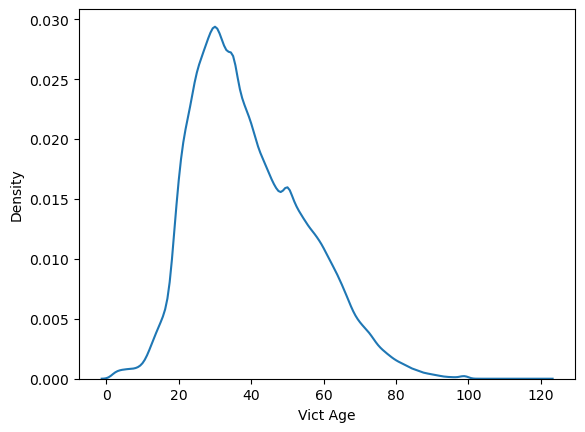

In [3]:
# let's look at some distributions
%matplotlib inline
from seaborn import kdeplot
# we need to drop ages = 0 to filter out unknowns
kdeplot(data=df[df['Vict Age'] > 0], x='Vict Age')

In [4]:
from folium import Icon
from folium import Map
from folium import Marker

sample_size = 500

# we have a limited color map so we loop it to pad it out
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple',
          'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray'] * 7
code_color_map = dict(zip(tuple(df['Crm Cd'].unique()), tuple(colors)))

# for some reason we have to fudge the center a little
lon_fudge = -0.5
location_map = Map(location=[df['LAT'].mean(), df['LON'].mean() + lon_fudge], zoom_start=10)
for index, row in df.sample(sample_size).iterrows():
    popup = '{}/{}/{}:{}'.format(row['LOCATION'], row['AREA NAME'], row['Crm Cd Desc'], row['Status'])
    Marker([row['LAT'], row['LON']], popup=popup, icon=Icon(color=code_color_map[row['Crm Cd']])).add_to(parent=location_map)

location_map

In [5]:
df.shape

(752911, 27)

In [6]:
df['Crm Cd'].nunique()

138

We have 138 codes; clearly we can't make sense of a pie with that many slices, so let's look at the top ten or so

In [7]:
crime_code_value_counts = df['Crm Cd Desc'].value_counts()
code_df = pd.DataFrame(data={'Code': crime_code_value_counts.index, 'Count': crime_code_value_counts.values}).reset_index(drop=True)
code_df.head(10)

,Code,Count
0,VEHICLE - STOLEN,80439
1,BATTERY - SIMPLE ASSAULT,59630
2,THEFT OF IDENTITY,48645
3,BURGLARY FROM VEHICLE,46526
4,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",46157
5,BURGLARY,45717
6,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",43149
7,THEFT PLAIN - PETTY ($950 & UNDER),38510
8,INTIMATE PARTNER - SIMPLE ASSAULT,37947
9,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),29310


In [8]:
import plotly.express as px
code_df.loc[code_df['Count'] < 15000, 'Code'] = 'Other' # we have too many codes so let's apply a threshold
px.pie(code_df, names='Code', values='Count').show()

In [9]:
# Surely the areas are shaped so the crime is roughly the same in each one; right?
area_value_counts = df['AREA NAME'].value_counts()
area_df = pd.DataFrame(data={'Area': area_value_counts.index, 'Count': area_value_counts.values}).reset_index(drop=True)
px.pie(area_df, names='Area', values='Count').show()

In [10]:
victim_descent = df['Vict Descent'].replace(to_replace={'B': 'Black', 'H': 'Hispanic', 'W': 'White',}).value_counts()
descent_df = pd.DataFrame(data={'Descent': victim_descent.index, 'Count': victim_descent.values}).reset_index(drop=True)
descent_df.loc[descent_df['Count'] < 80000, 'Descent'] = 'Other' # threshold
px.pie(descent_df, names='Descent', values='Count').show()

<Axes: xlabel='DATE OCC'>

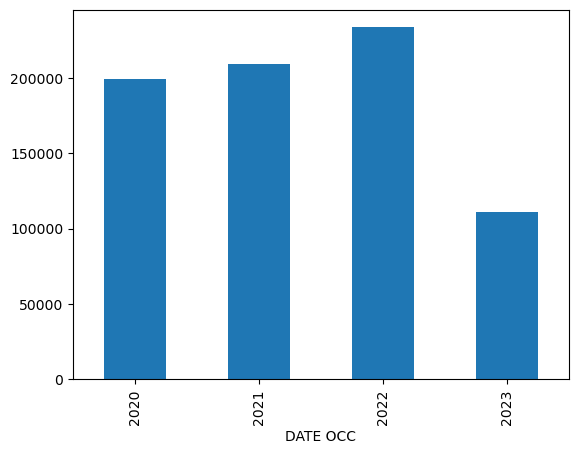

In [11]:
# not surprisingly we have an incomplete current year
df['DATE OCC'].groupby(df['DATE OCC'].dt.year).count().plot(kind='bar')

<Axes: xlabel='DATE OCC'>

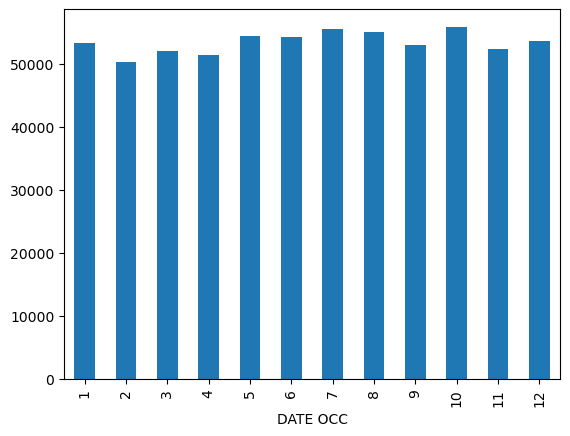

In [12]:
# where we have complete years we do not have obvious seasonality
df[df['DATE OCC'].dt.year < 2023]['DATE OCC'].groupby(df['DATE OCC'].dt.month).count().plot(kind='bar')

<Axes: xlabel='DATE OCC'>

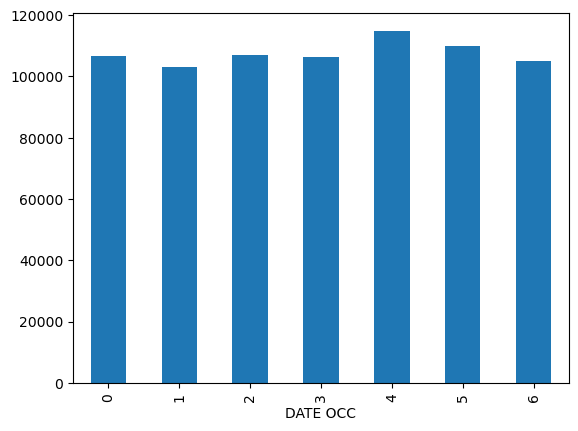

In [13]:
# nor do weekends seem to matter much
df['DATE OCC'].groupby(df['DATE OCC'].dt.dayofweek).count().plot(kind='bar')

<Axes: xlabel='DATE OCC', ylabel='Density'>

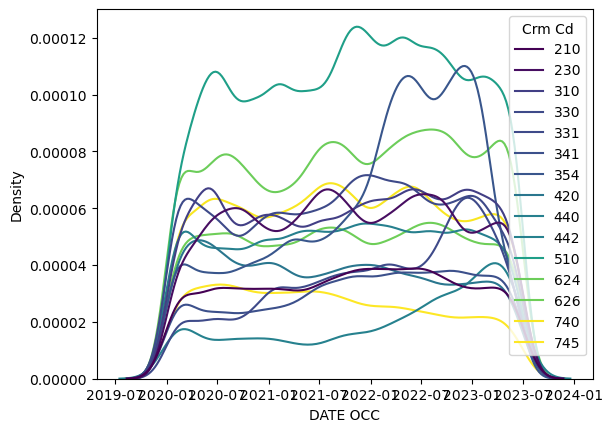

In [14]:
# if we segment by crime code do we see anything interesting?
kdeplot(data=df[df['Crm Cd'].isin(df['Crm Cd'].value_counts()[:15].index.tolist())], x='DATE OCC', hue='Crm Cd', palette='viridis')

<Axes: xlabel='DATE OCC', ylabel='Density'>

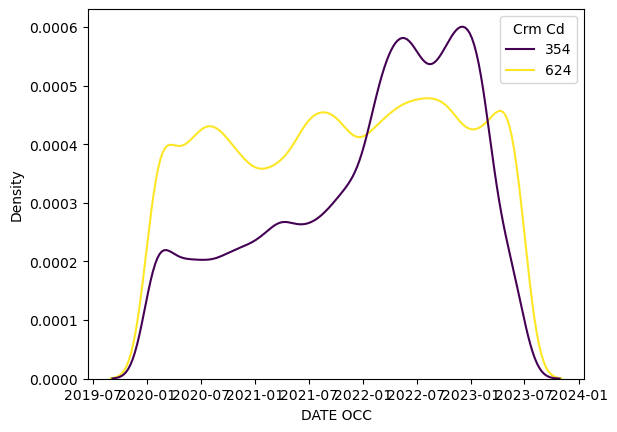

In [15]:
# we see a persistent surge in one code; which one is it?
kdeplot(data=df[df['Crm Cd'].isin(df['Crm Cd'].value_counts()[1:3].index.tolist())], x='DATE OCC', hue='Crm Cd', palette='viridis')

In [16]:
df[df['Crm Cd'].isin(df['Crm Cd'].value_counts()[:10].index.tolist())][['Crm Cd', 'Crm Cd Desc']].drop_duplicates()

,Crm Cd,Crm Cd Desc
0,624,BATTERY - SIMPLE ASSAULT
4,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA..."
10,330,BURGLARY FROM VEHICLE
15,626,INTIMATE PARTNER - SIMPLE ASSAULT
17,440,THEFT PLAIN - PETTY ($950 & UNDER)
18,354,THEFT OF IDENTITY
24,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT"
30,310,BURGLARY
33,510,VEHICLE - STOLEN
45,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)


Identity theft seems like kind of a surprise, doesn't it?

In [17]:
# is identity theft a secular trend or is the rise concentrated in one ethnic group? 
identity_df = df[df['Crm Cd'] == 354]
identity_victim_descent = identity_df['Vict Descent'].replace(to_replace={'B': 'Black', 'H': 'Hispanic', 'W': 'White',}).value_counts()
identity_descent_df = pd.DataFrame(data={'Descent': identity_victim_descent.index, 'Count': identity_victim_descent.values}).reset_index(drop=True)
identity_descent_df.loc[identity_descent_df['Count'] < 8000, 'Descent'] = 'Other' # threshold
px.pie(identity_descent_df, names='Descent', values='Count').show()